# Shapley values in practise
## Mateusz Baran
### 155620

In [113]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from eli5 import show_weights

In [114]:
CV_N_REPEATS = 5
BINS = 10

In [115]:
df = pd.read_csv('data/Tourists_lakes_Nature.csv')
df.head()

,Area,Mean depth,Shorline lenght,Coast development index,Lake elongation index,Shorline overgrowth degree,Vegeation coverage of lake,Forests around the coasline,Tourism
0,43.3,3.7,2896,1.19,2.009346,60,3,13.987108,1
1,48.7,6.1,3293,1.33,1.916667,51,12,53.262759,1
2,167.8,6.9,7228,1.55,2.342995,60,20,52.702899,1
3,89.6,6.0,10085,2.83,7.777778,35,7,75.000000,0
4,81.2,4.5,4391,1.38,2.093750,49,8,68.805422,1


In [116]:
print('Shape of the dataset', df.shape)

Shape of the dataset (145, 9)


Elementary data anylysis (EDA)

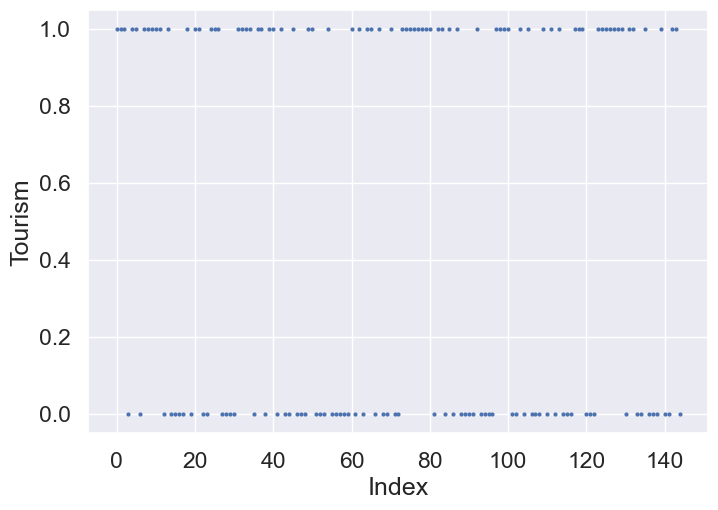

In [117]:
plt.figure()
plt.plot(df.Tourism, '.')
plt.xlabel('Index')
plt.ylabel('Tourism')
plt.show()

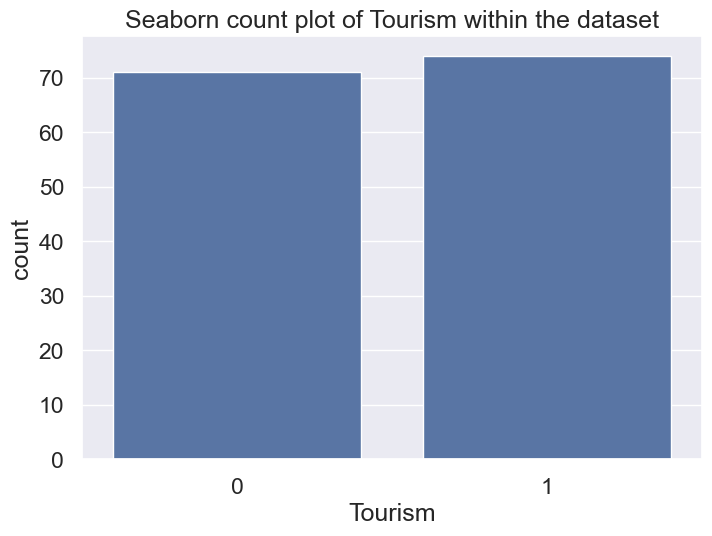

In [118]:
plt.figure()
ax = sns.countplot(data=df, x='Tourism')
ax.set_title('Seaborn count plot of Tourism within the dataset')
plt.show()

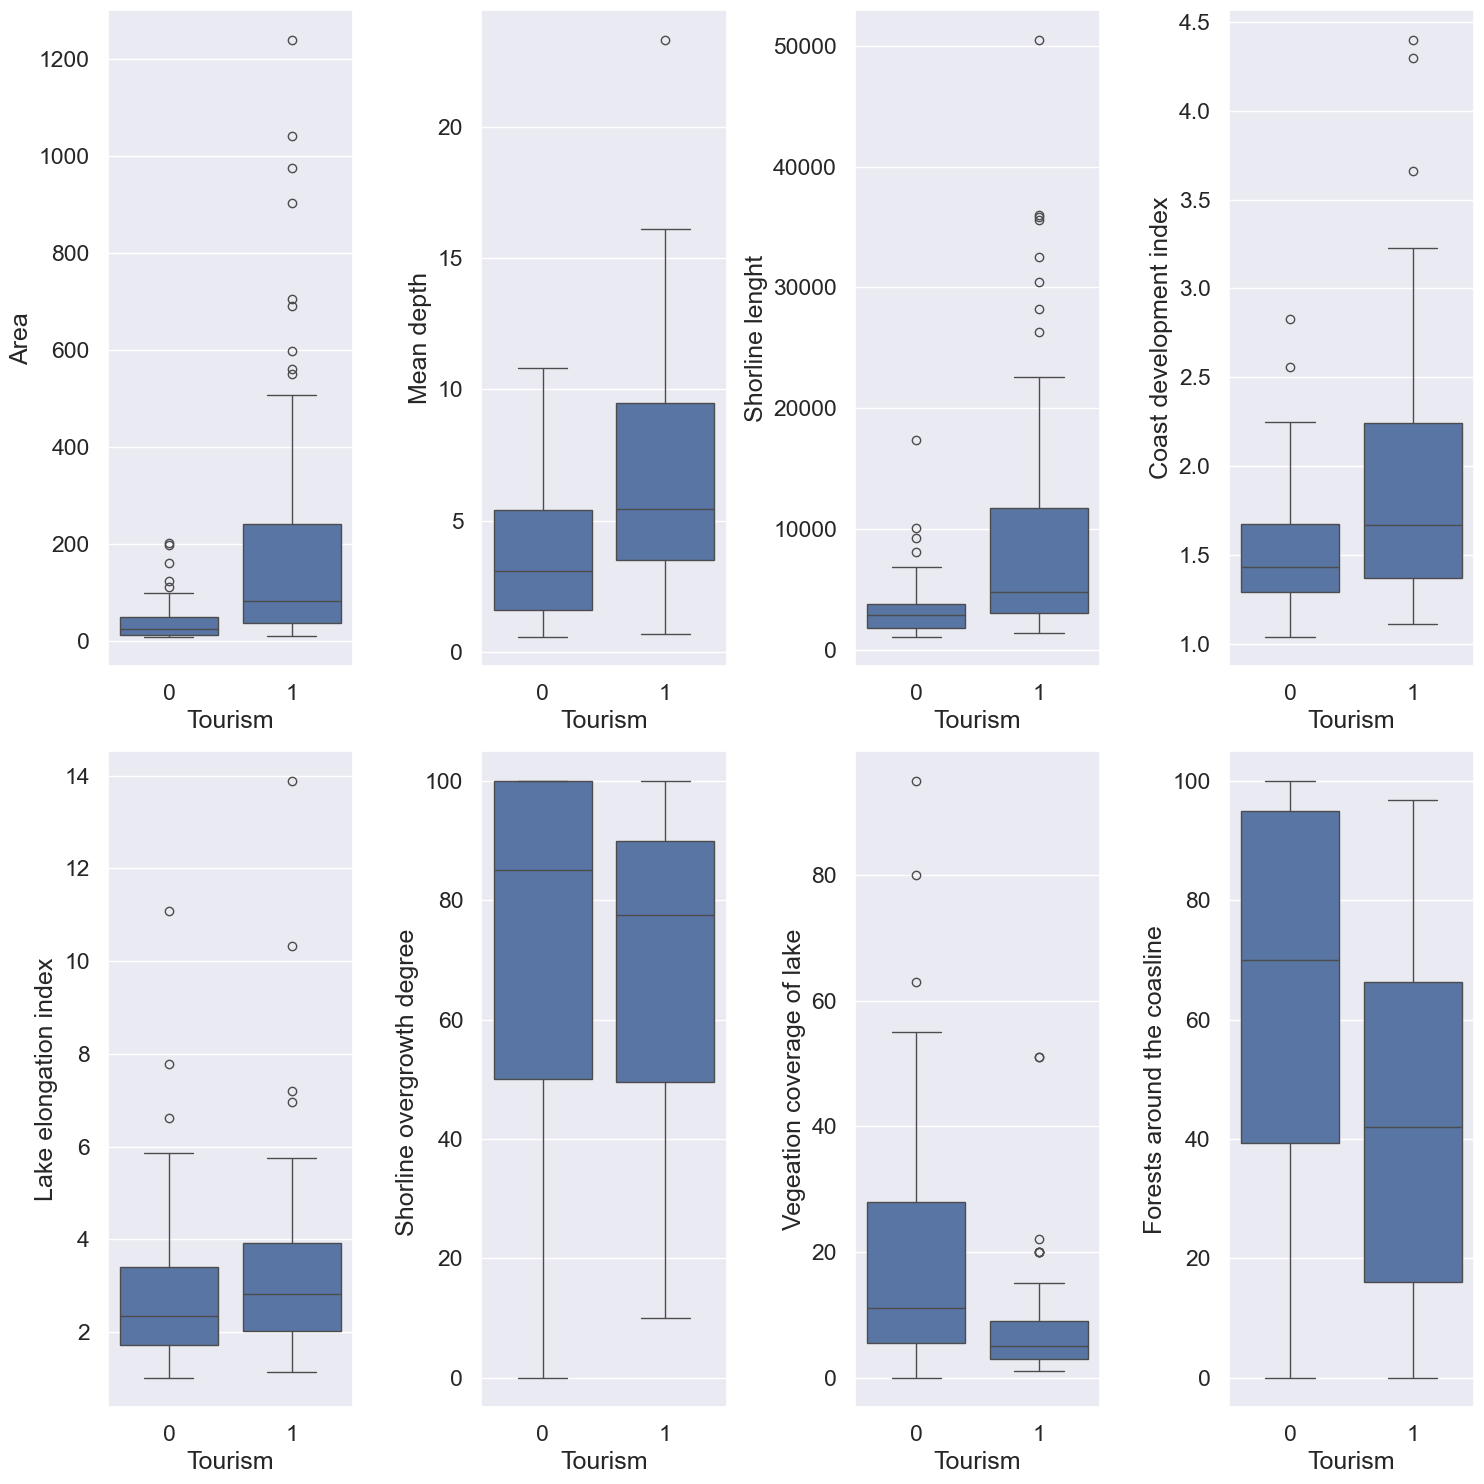

In [119]:
f, axes = plt.subplots(2, 4, figsize=(15,15))
sns.set(style='white', palette='Set3', color_codes=True)
sns.boxplot(y='Area', x='Tourism', data=df, orient='v', ax=axes[0,0])
sns.boxplot(y='Mean depth', x='Tourism', data=df, orient='v', ax=axes[0,1])
sns.boxplot(y='Shorline lenght', x='Tourism', data=df, orient='v', ax=axes[0,2])
sns.boxplot(y='Coast development index', x='Tourism', data=df, orient='v', ax=axes[0,3])
sns.boxplot(y='Lake elongation index', x='Tourism', data=df, orient='v', ax=axes[1,0])
sns.boxplot(y='Shorline overgrowth degree ', x='Tourism', data=df, orient='v', ax=axes[1,1])
sns.boxplot(y='Vegeation coverage of lake', x='Tourism', data=df, orient='v', ax=axes[1,2])
sns.boxplot(y='Forests around the coasline', x='Tourism', data=df, orient='v', ax=axes[1,3])
f.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)
plt.tight_layout()
plt.show()

In [120]:
df_copy = df.copy(deep=True)
print(df_copy.isnull().sum())

Area                           0
Mean depth                     0
Shorline lenght                0
Coast development index        0
Lake elongation index          0
Shorline overgrowth degree     0
Vegeation coverage of lake     0
Forests around the coasline    0
Tourism                        0
dtype: int64


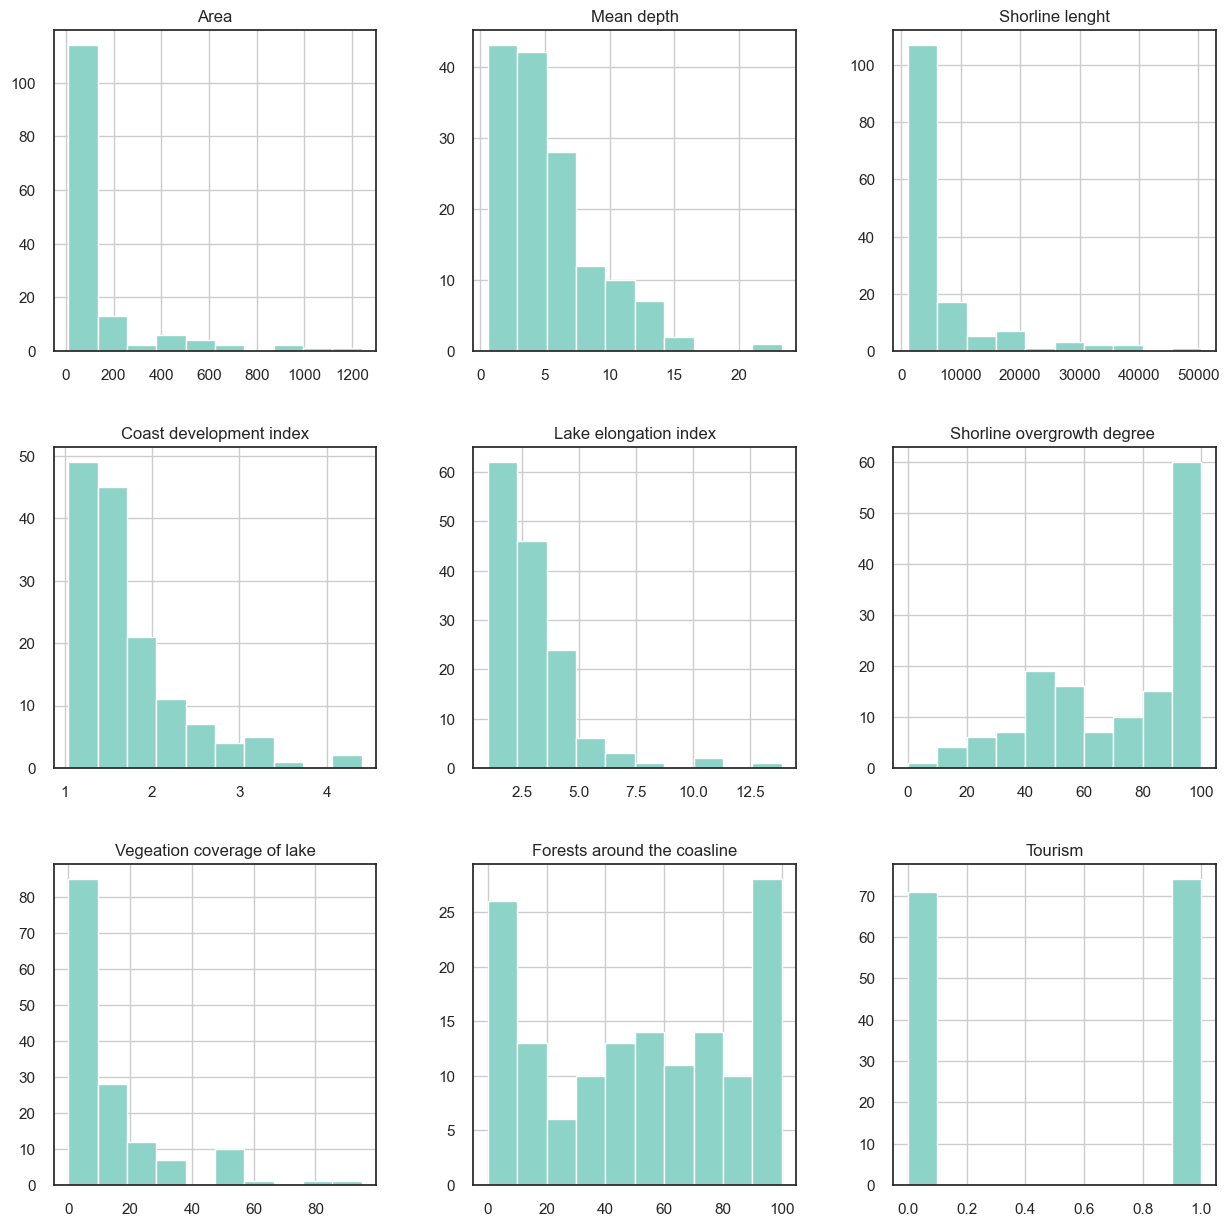

In [121]:
p = df.hist(figsize=(15,15))

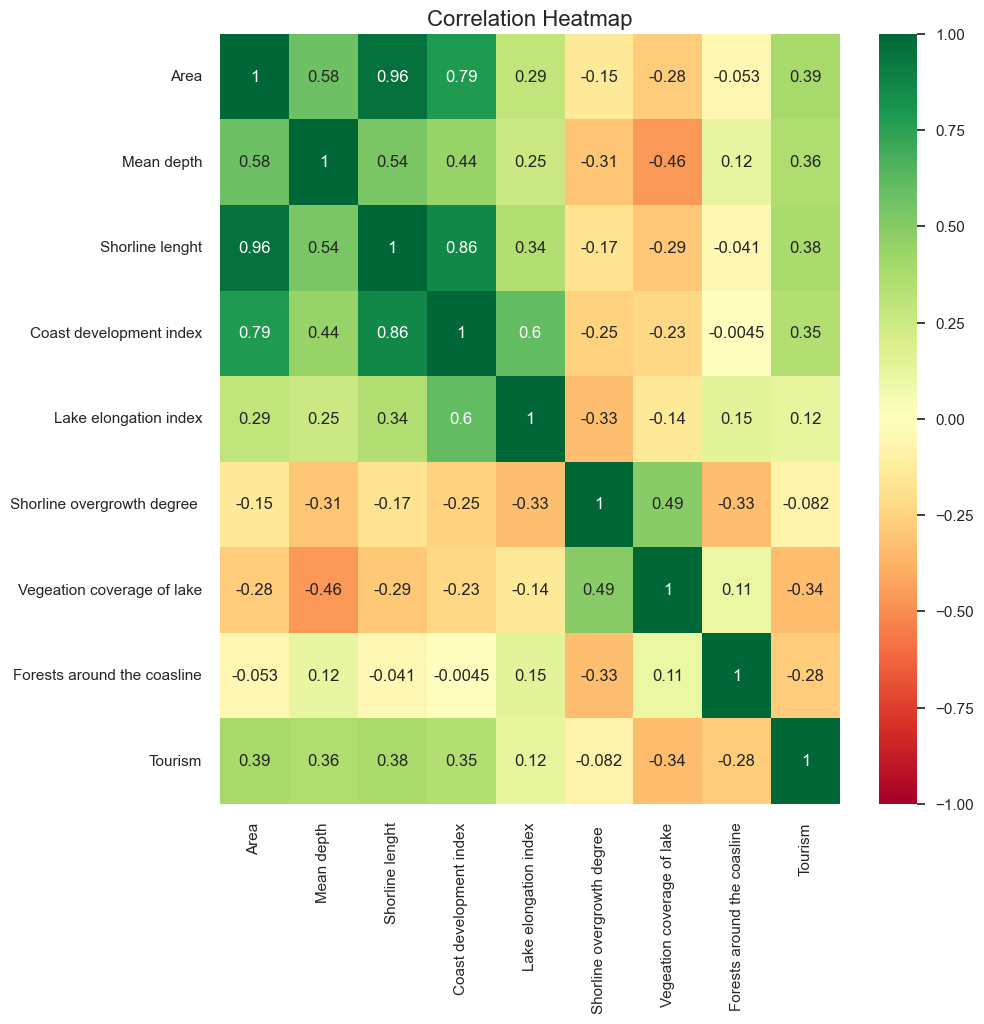

In [122]:
# plot the correlation map of the dataset
plt.figure(figsize=(10,10))
corr = df_copy.corr()
corr.index = df_copy.columns
sns.heatmap(corr, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

<Figure size 800x550 with 0 Axes>

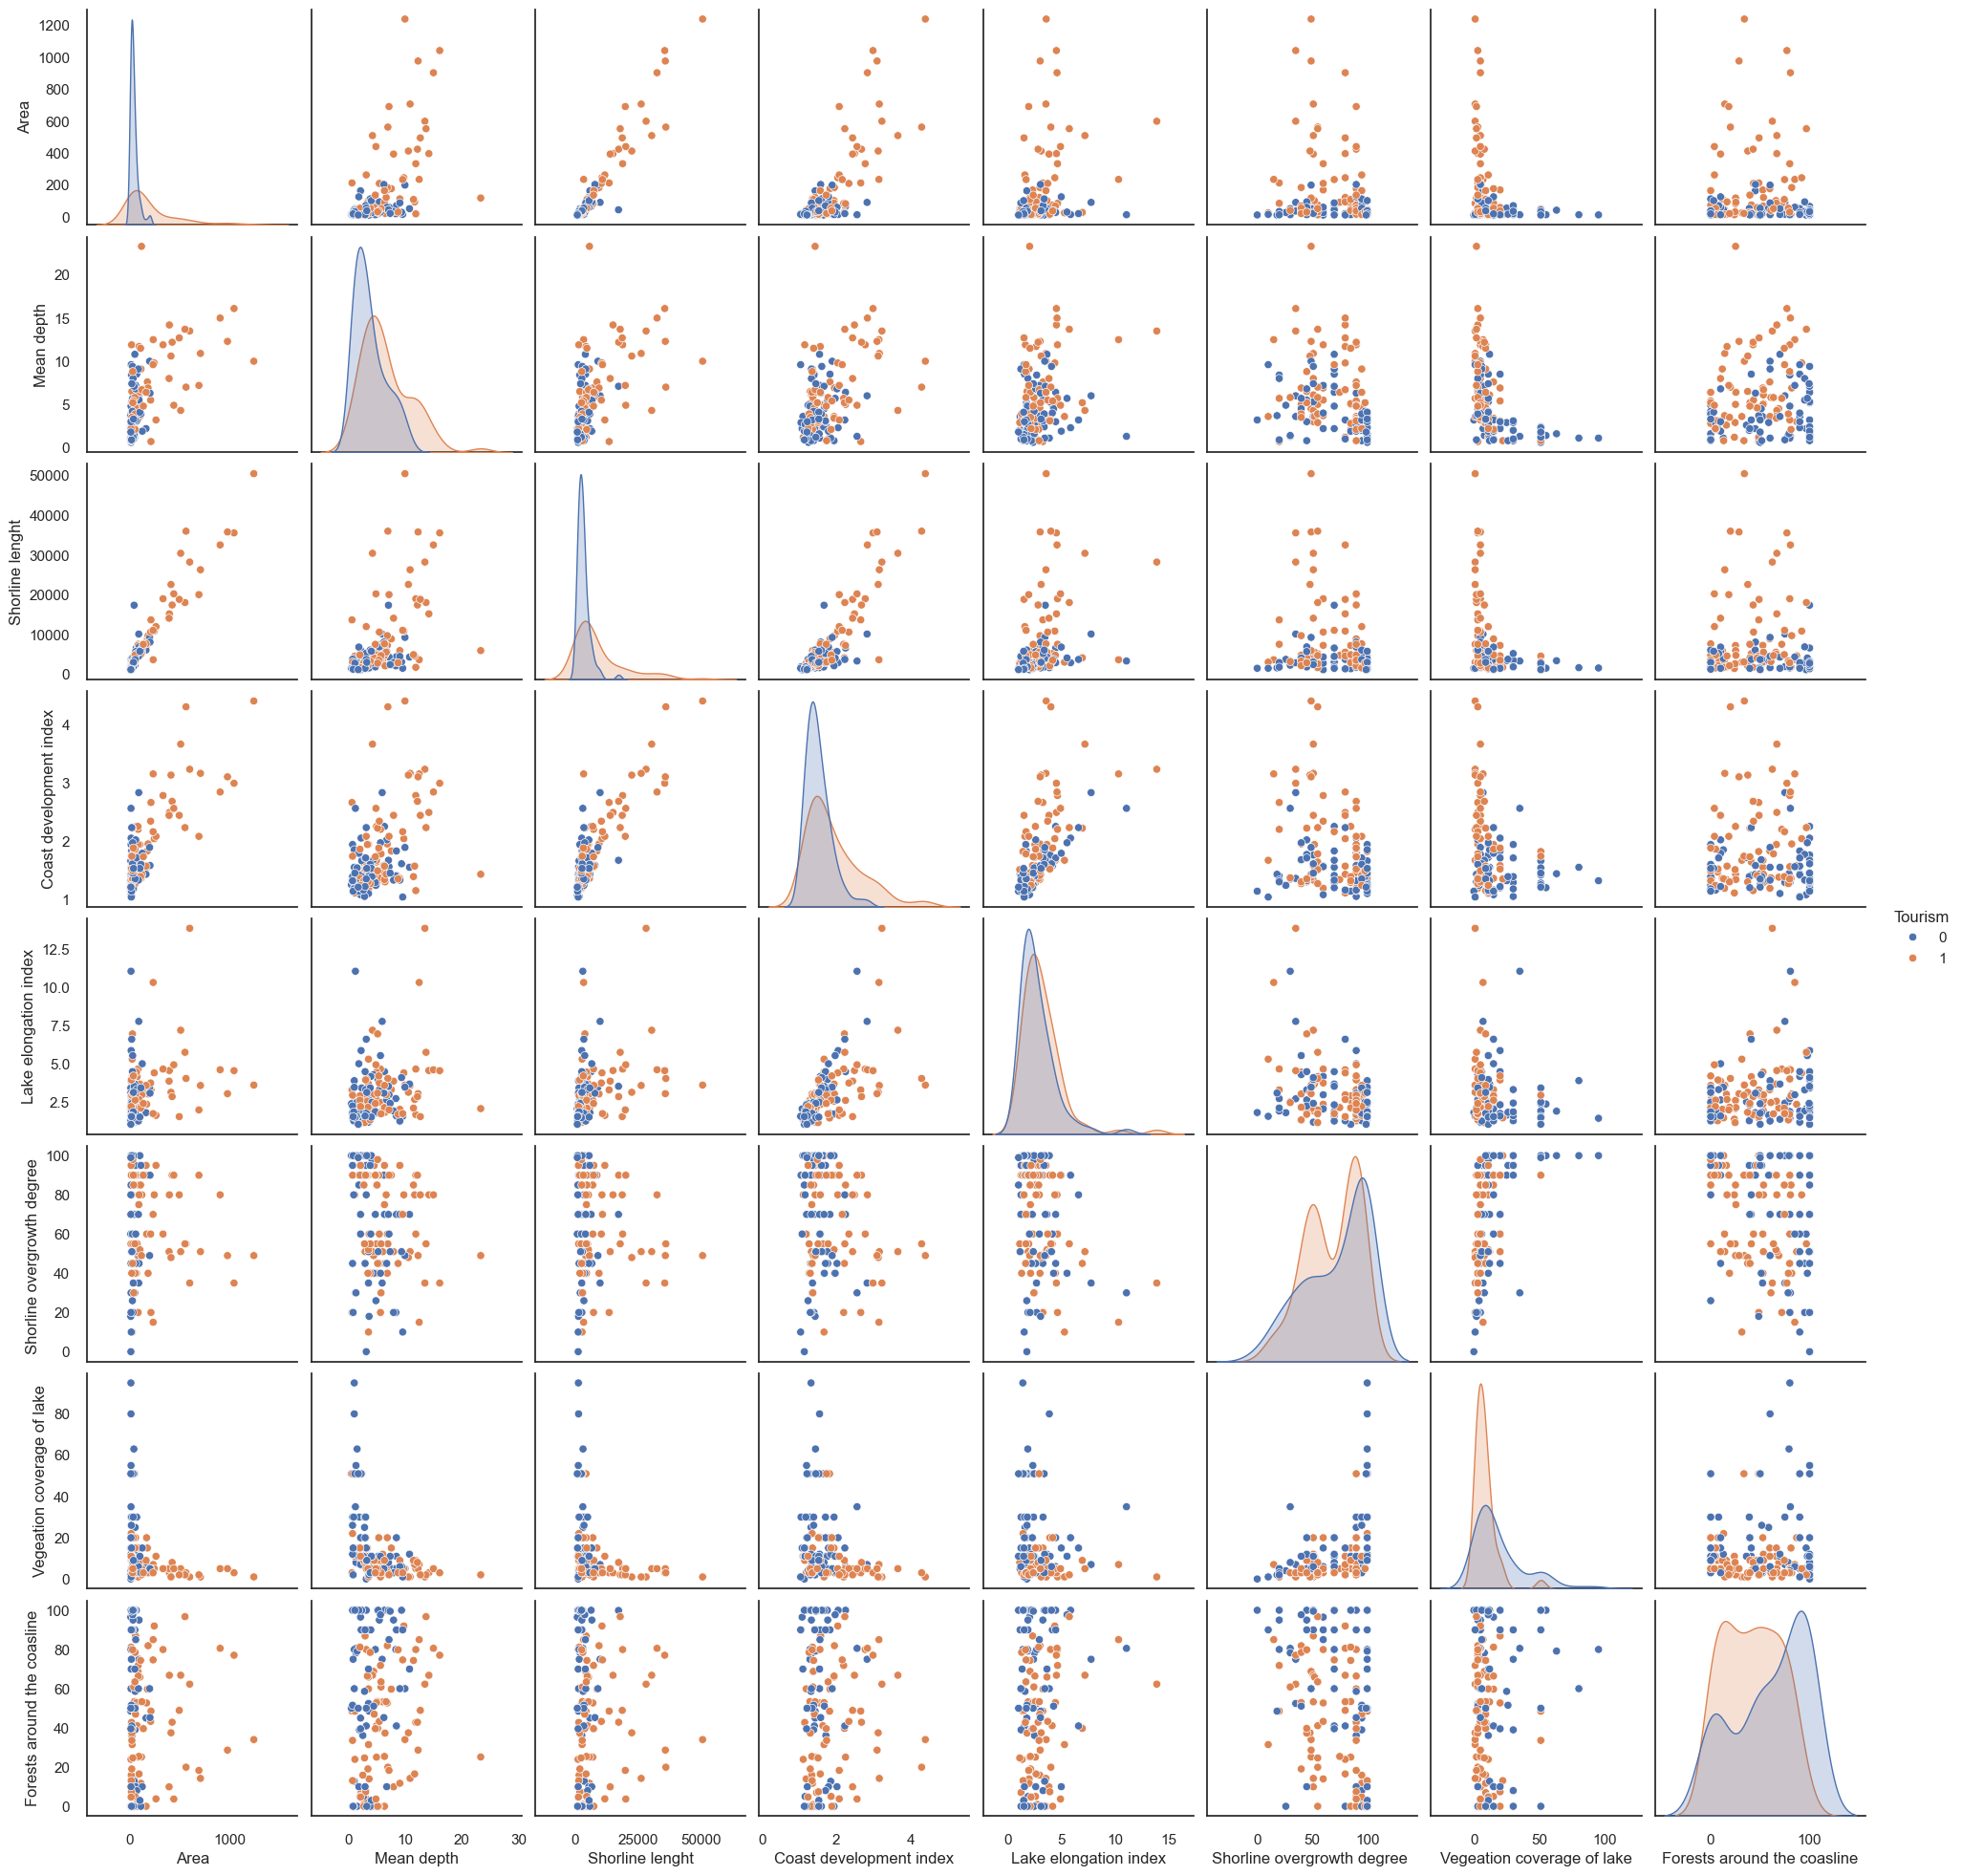

In [123]:
plt.figure()
sns.pairplot(data=df_copy, hue='Tourism', diag_kind='kde', palette='deep')

### Model Building

In [124]:
# DummyClassifier
# we start with the most basic, a dummy classifier with predicts the most frequent class at all times.
# this would serve as our baseline. Split X, y into train and test sets.
# we use the original data instead of the PCA transformed data.

In [125]:
X = df_copy.iloc[:, 0:8]
Y = df_copy.iloc[:, 8]
seed = 7
test_size = 0.30
X_train, X_test, y_tran, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape)

Shape of X_train (101, 8)
Shape of X_test (44, 8)


In [126]:
strategy='most_frequent'
dum = DummyClassifier(strategy=strategy)
dum = dum.fit(X_train, y_tran)

# compute accuracy
score=dum.score(X_test, y_test)
print('Dummy Classifier accuracy: %.2f%%' % (score*100.0))

Dummy Classifier accuracy: 45.45%


<Figure size 700x700 with 0 Axes>

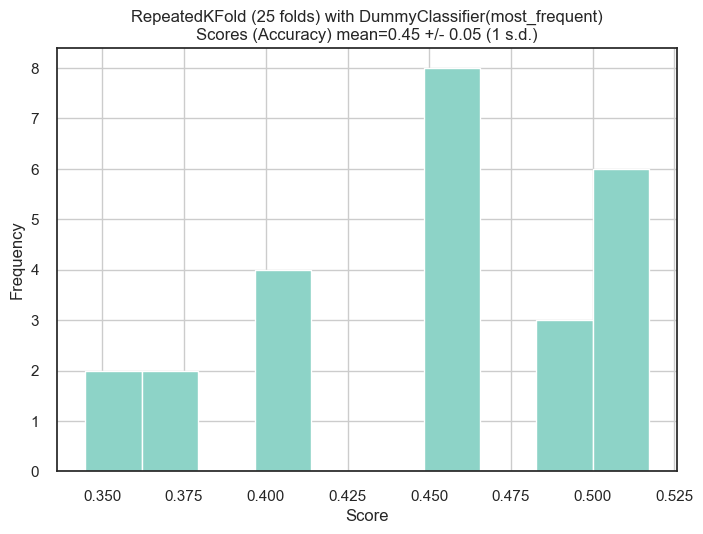

In [127]:
scores = cross_val_score(dum, X , Y, cv=RepeatedKFold(n_repeats=CV_N_REPEATS), scoring=None)
scores_dummy = scores.copy()
score_line = 'Scores (Accuracy) mean={0:.2f} +/- {1:.2f} (1 s.d.)'.format(
    scores.mean(), scores.std()
)
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f'RepeatedKFold ({len(scores)} folds) with DummyClassifier({strategy})\n' + score_line)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
plt.show()

In [128]:
# helper functions for graphical plotting of decision trees and to plot confusion matrix
def plot_tree_graph(model, columns, class_names):
    dot_data = export_graphviz(model, feature_names=columns, class_names=class_names)
    graph = graphviz.Source(dot_data)
    return graph

def confusion_mat(y_pred, y_test):
    plt.figure()
    sns.set(font_scale=1.5)
    cm = confusion_matrix(y_pred, y_test)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [129]:
# decision tree
dt=DecisionTreeClassifier(random_state=1, max_depth=3)
dt=dt.fit(X_train, y_tran)
dt_scores = cross_val_score(dt, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print(f'Accuracy mean = {dt_scores.mean():0.2f} +/- {dt_scores.std():0.2f} (1 s.d.)')

Accuracy mean = 0.67 +/- 0.09 (1 s.d.)


In [130]:
# Bagging Classifier
bag = BaggingClassifier(n_estimators=100, oob_score=True)
bag = bag.fit(X_train, y_tran)
bag_scores = cross_val_score(bag, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print('Accuracy mean = {0:0.2f} +/- {1:0.2f} (1 s.d.)'.format(bag_scores.mean(), bag_scores.std()))
print('Out of bag score: {0:0.2f}'.format(bag.oob_score_ * 100))

Accuracy mean = 0.69 +/- 0.07 (1 s.d.)
Out of bag score: 67.33


Accuracy of Random Forest Classifier: 68.18


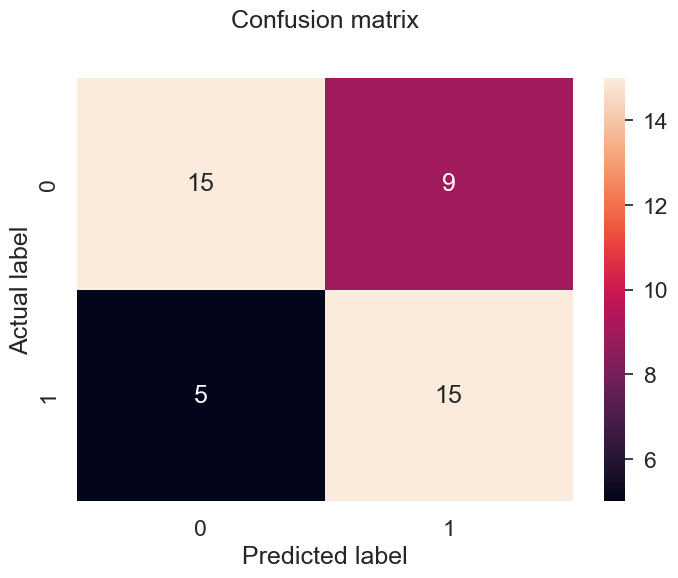

In [131]:
# Random Forest

num_estimator = 100
rf = RandomForestClassifier(n_estimators=num_estimator)
rf.fit(X_train, y_tran)
rf_score = rf.score(X_test, y_test)
print("Accuracy of Random Forest Classifier: {0:0.2f}".format(rf_score * 100.0))

y_pred = rf.predict(X_test)
confusion_mat(y_pred, y_test)

In [132]:
feature_names = X_train.columns.values
show_weights(rf, feature_names=feature_names)

Weight,Feature
0.1790 ± 0.2815,Area
0.1691 ± 0.2531,Shorline lenght
0.1670 ± 0.1867,Forests around the coasline
0.1150 ± 0.1457,Lake elongation index
0.1099 ± 0.1819,Coast development index
0.1003 ± 0.1523,Shorline overgrowth degree
0.0919 ± 0.1415,Mean depth
0.0678 ± 0.1298,Vegeation coverage of lake


Scores mean = 0.70 +/- 0.09 (1 s.d.)


<Figure size 800x550 with 0 Axes>

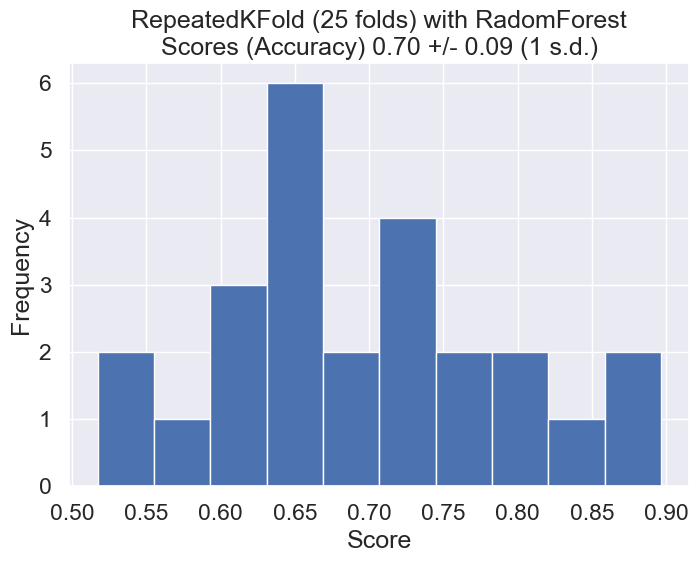

In [133]:
scores = cross_val_score(rf, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
scores_est = scores.copy()
print(f'Scores mean = {scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)')
score_line = f'Scores (Accuracy) {scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)'
plt.figure()
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f'RepeatedKFold ({len(scores)} folds) with RadomForest\n' + score_line)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
plt.show()

In [134]:
# gradient boosting classifier (sklearn)
from sklearn.metrics import mean_squared_error
params = {'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': 5, 'loss': 'deviance'}
gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_tran)

/opt/homebrew/Caskroom/miniconda/base/envs/ml_3_10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


GradientBoostingClassifier(learning_rate=0.01, loss='deviance', max_depth=5,
                           n_estimators=500)

/opt/homebrew/Caskroom/miniconda/base/envs/ml_3_10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ml_3_10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ml_3_10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ml_3_10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


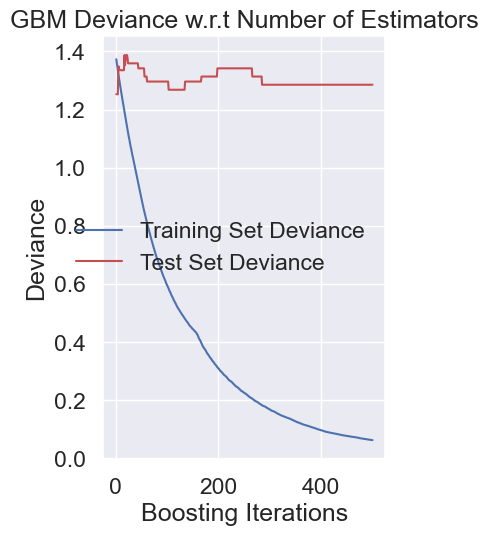

In [135]:
test_score = np.zeros((params['n_estimators'], ), dtype=np.float64)
for i, y_pred in enumerate(gbm.staged_predict(X_test)):
    test_score[i] = gbm.loss_(y_test, y_pred)

plt.figure()
plt.subplot(1, 2, 1)
plt.title('GBM Deviance w.r.t Number of Estimators')
plt.plot(np.arange(params['n_estimators']) + 1, gbm.train_score_, 'b-', label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set Deviance')
plt.legend(loc='best')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/ml_3_10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


Accuracy of GBM Classifier: 61.36363636363637


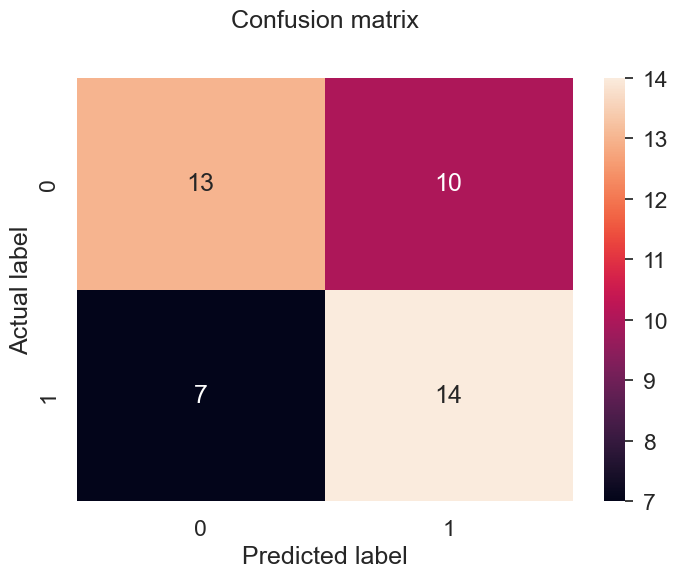

In [136]:
params = {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 4, 'loss': 'deviance'}
gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_tran)

y_pred = gbm.predict(X_test)
gbm_score = accuracy_score(y_test, y_pred)
print(f'Accuracy of GBM Classifier: {gbm_score * 100.0}')
confusion_mat(y_pred, y_test)

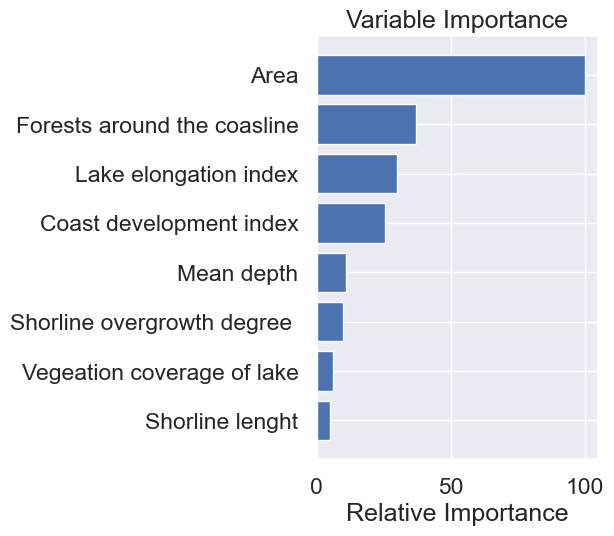

In [137]:
# Plot Feature Importance for the GBM model

feature_importance = gbm.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [138]:
# XgBoost

from xgboost import XGBClassifier, plot_importance, to_graphviz

param = {'max_depth': 10, 'eta': 0.8, 'subsample': 1, 'objective': 'binary:logistic', 'n_estimators': 1000, 'learning_rate': 0.001}
xgb = XGBClassifier(**param)
xgb.fit(X_train, y_tran)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.8, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

Accuracy of XGB Classifier: 59.09


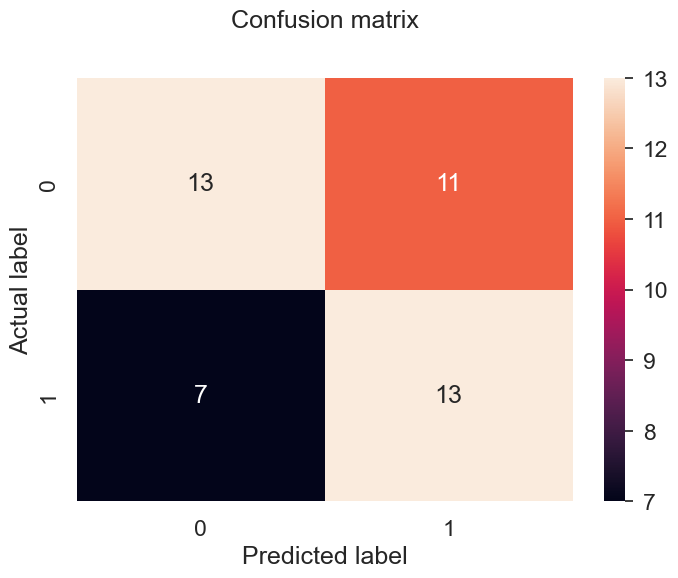

In [139]:
y_pred = xgb.predict(X_test)
xgb_score = accuracy_score(y_test, y_pred)
print('Accuracy of XGB Classifier: {0:0.2f}'.format(xgb_score * 100.0))
confusion_mat(y_pred, y_test)

<Figure size 800x550 with 0 Axes>

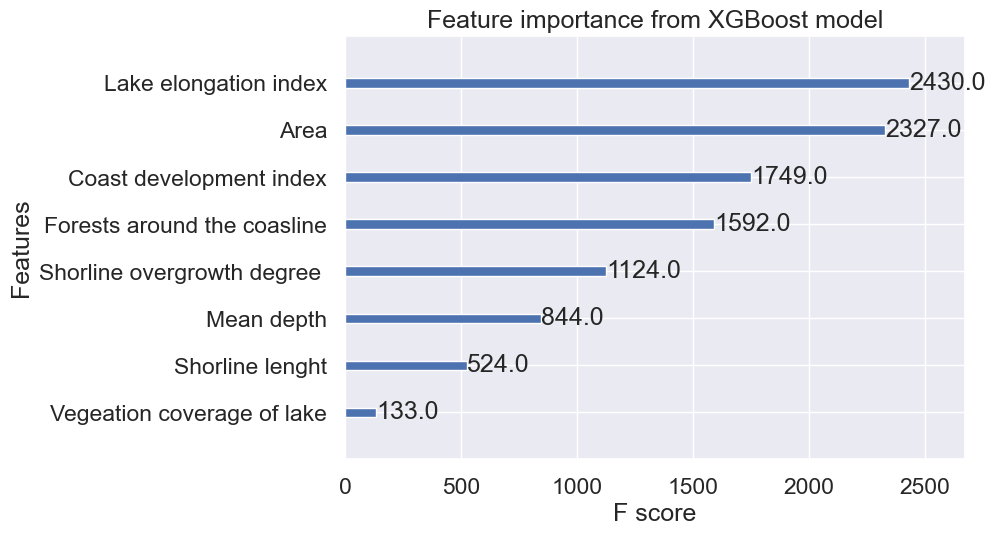

In [140]:
plt.figure()
plot_importance(xgb, title='Feature importance from XGBoost model')
plt.show()

### Wnioski:
#### Aktualnie najlepszy okazuje się model: Random Forest Classifier: 68.18

In [141]:
data = pd.read_csv('data/Tourists_lakes_Nature.csv')
data.dropna(inplace=True)
X = pd.get_dummies(data)
X.drop(['Tourism'], inplace=True, axis=1)
y = data['Tourism']

In [142]:
data.head()

,Area,Mean depth,Shorline lenght,Coast development index,Lake elongation index,Shorline overgrowth degree,Vegeation coverage of lake,Forests around the coasline,Tourism
0,43.3,3.7,2896,1.19,2.009346,60,3,13.987108,1
1,48.7,6.1,3293,1.33,1.916667,51,12,53.262759,1
2,167.8,6.9,7228,1.55,2.342995,60,20,52.702899,1
3,89.6,6.0,10085,2.83,7.777778,35,7,75.000000,0
4,81.2,4.5,4391,1.38,2.093750,49,8,68.805422,1


In [143]:
X = X.iloc[:, 0:8]
y = y.iloc[:,]
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape)

Shape of X_train (101, 8)
Shape of X_test (44, 8)


In [144]:
model = XGBClassifier(n_estimators=1000, max_depth=10, learing_rate=0.001)
model.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniconda/base/envs/ml_3_10/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:13:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "learing_rate" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learing_rate=0.001,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [145]:
y_pred = model.predict(X_test)
model_score = accuracy_score(y_test, y_pred)
print('Accuracy of XGB Calssifier: {0:0.2f}'.format(model_score * 100.0))
confusion_matrix(y_pred, y_test)

Accuracy of XGB Calssifier: 63.64


array([[17, 13],
       [ 3, 11]])

In [146]:
import shap
shap.initjs()

In [147]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [148]:
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

In [149]:
i = 109
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

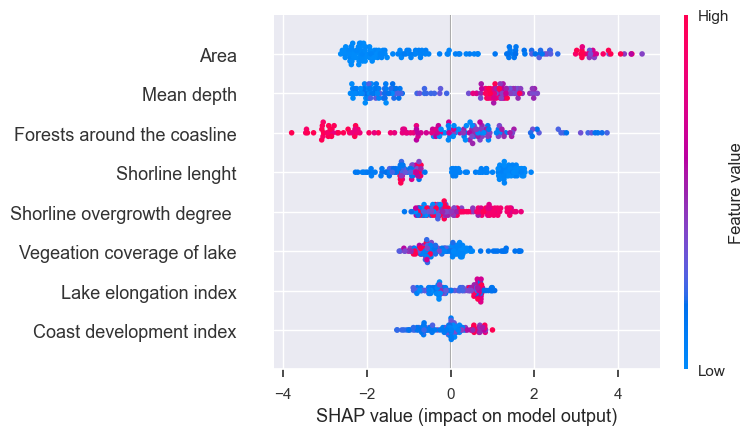

In [150]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, show=False)
plt.show()

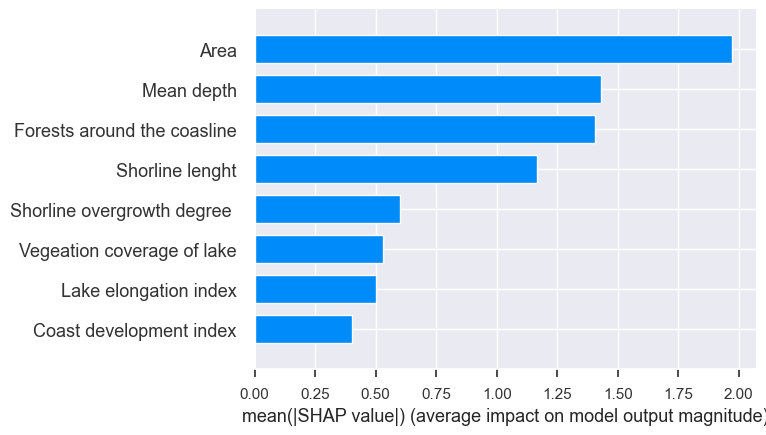

In [151]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, show=False, plot_type='bar')
plt.show()

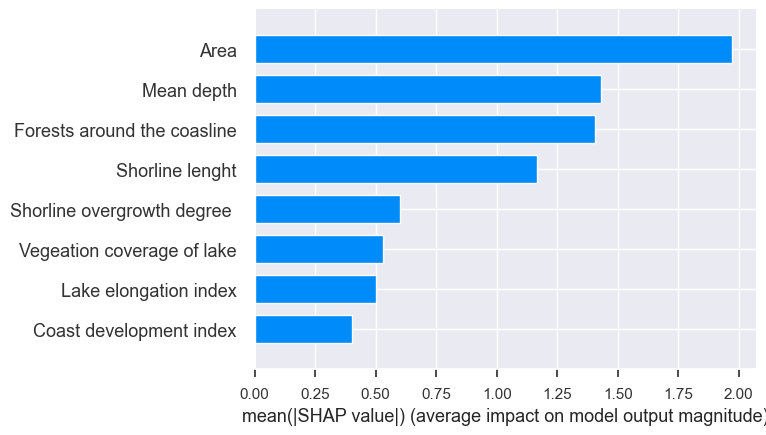

In [152]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, show=False, plot_type='bar')
plt.show()

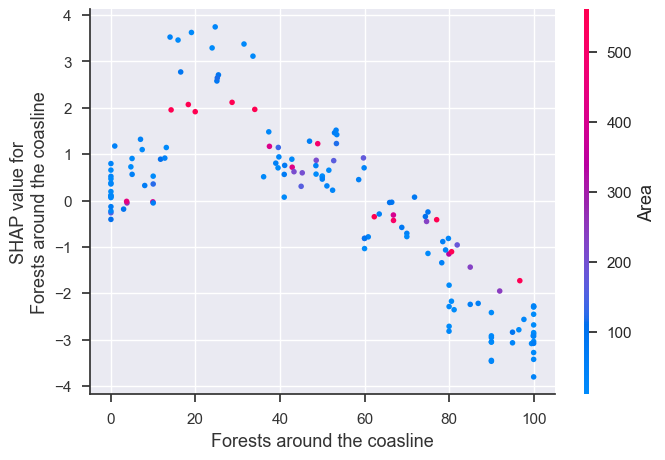

In [153]:
shap.dependence_plot('Forests around the coasline', shap_values, features=X, interaction_index='Area')

In [154]:
shap.force_plot(explainer.expected_value, shap_values[:121,:], show=False, features=X.iloc[:121,:])

## Wnioski
Najbardziej wrażliwe są parametry: Forest around the coasline, Area oraz Vegeation coverange of lake. Najbardziej odporne parametry to: Coast development index oraz Shorline lenght
